Instalando bibliotecas necessárias (xgboost==1.7.6, shap==0.44.1)...
Bibliotecas instaladas e importadas com sucesso.
Versões: scikit-learn=1.6.1 | xgboost=3.1.1 | shap=0.49.1

--- ⬆️ AÇÃO NECESSÁRIA: Upload dos Dados ---
Por favor, selecione o seu arquivo 'Telco-Customer-Churn.csv'...


Saving Churn.csv to Churn (9).csv

Arquivo 'Churn (9).csv' carregado com sucesso.
--- Amostra dos Dados (5 primeiras linhas) ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No     

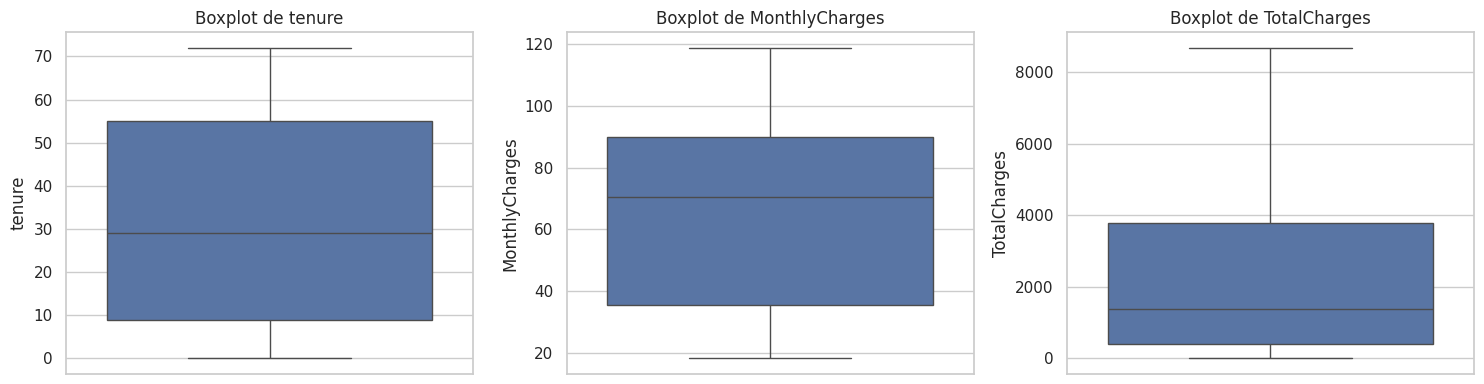


Features Numéricas (escalonadas): ['tenure', 'MonthlyCharges', 'TotalCharges']
Features Categóricas (One-Hot): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Pipeline de pré-processamento ('preprocessor') criado com sucesso.
Dados divididos: 5634 para treino, 1409 para teste.
Proporção de Churn no Treino: 26.54%
Proporção de Churn no Teste: 26.54%

--- ETAPA 2: Iniciando Modelagem ---

Treinando modelos e avaliando no TESTE...

=== Regressão Logística (TESTE) ===
AUC: 0.8421
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.61       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

PermutationExplainer explainer: 1410it [03:20,  6.85it/s]

Valores SHAP calculados.



--- Gráfico 1: Importância Média (SHAP) ---


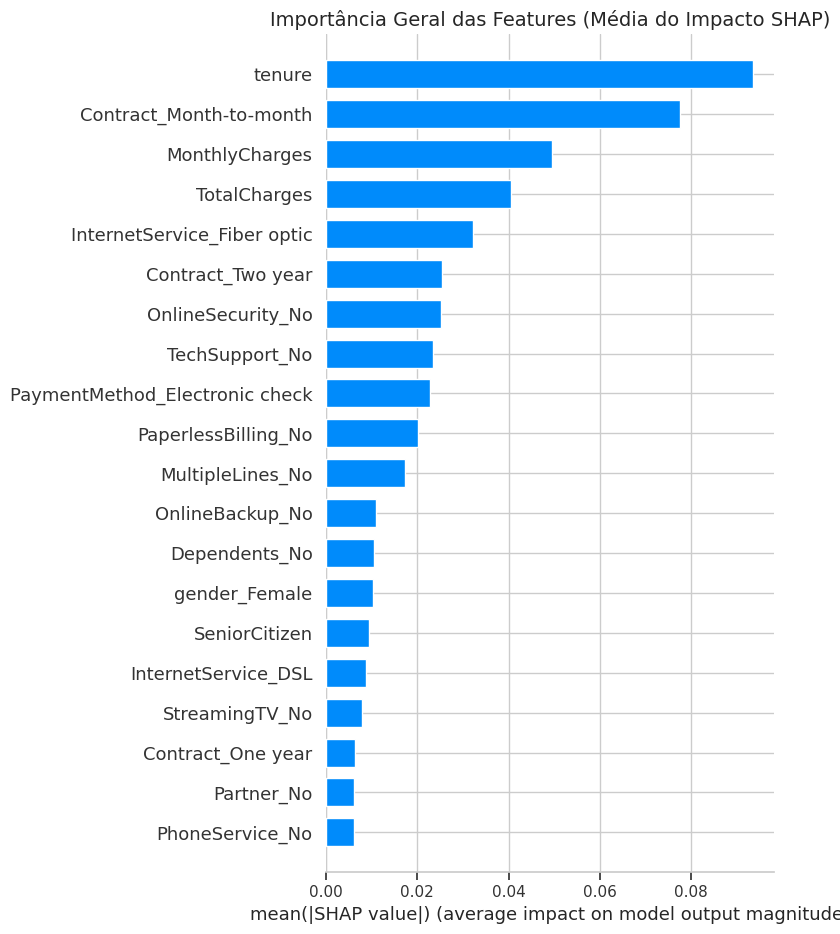


--- Gráfico 2: Impacto Detalhado (Beeswarm) ---


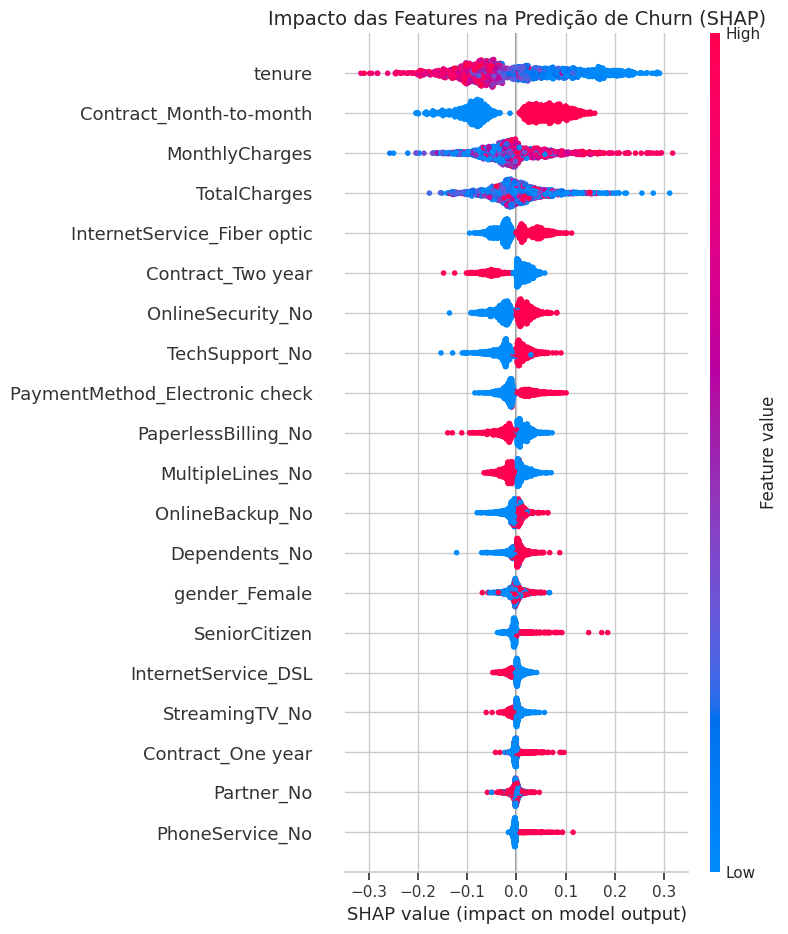


--- PIPELINE CONCLUÍDO COM SUCESSO ✅ ---


In [11]:
# Pipeline Completo: Churn de Clientes - Telecomunicações
# - Pré-processamento: tratamento de TotalCharges, encoding categóricas, escalonamento numéricas
# - Modelagem: Regressão Logística vs XGBoost (com pipelines sklearn)
# - Métricas: AUC-ROC, classification report, validação estratificada
# - Explicabilidade: SHAP values com fallbacks (TreeExplainer + Permutation)
# - Gráficos: boxplots outliers, importância features, beeswarm plot SHAP
# - Validação: split estratificado, compatibilidade versões sklearn/xgboost

def rodar_pipeline_completo():
    # ----------------------------------------------------------------------
    # ETAPA 0: PREPARAÇÃO (IMPORTAÇÕES E DADOS)
    # ----------------------------------------------------------------------
    print("Instalando bibliotecas necessárias (xgboost==1.7.6, shap==0.44.1)...")
    try:
        # Fixando versões compatíveis (evita erro do base_score no SHAP)
        !pip install -q xgboost==1.7.6 shap==0.44.1
    except Exception as e:
        print(f"Aviso: Falha na instalação (pode já estar instalado). Erro: {e}")

    import pandas as pd
    import numpy as np
    import io
    import json
    import matplotlib.pyplot as plt
    import seaborn as sns
    import warnings

    from google.colab import files

    from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    import sklearn

    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier

    from sklearn.metrics import classification_report, roc_auc_score

    import shap

    sns.set(style="whitegrid")
    pd.set_option("display.max_columns", None)
    warnings.filterwarnings("ignore")

    print("Bibliotecas instaladas e importadas com sucesso.")
    print(f"Versões: scikit-learn={sklearn.__version__} | xgboost={(__import__('xgboost')).__version__} | shap={shap.__version__}")

    # --- Upload dos Dados ---
    print("\n--- ⬆️ AÇÃO NECESSÁRIA: Upload dos Dados ---")
    print("Por favor, selecione o seu arquivo 'Telco-Customer-Churn.csv'...")
    try:
        uploaded = files.upload()
        file_name = list(uploaded.keys())[0]
        print(f"\nArquivo '{file_name}' carregado com sucesso.")

        df = pd.read_csv(io.BytesIO(uploaded[file_name]))
        print("--- Amostra dos Dados (5 primeiras linhas) ---")
        print(df.head())
        print("\n" + "=" * 80)
    except Exception as e:
        print("\n--- ERRO NO UPLOAD ---")
        print(f"Não foi possível carregar o arquivo. Erro: {e}")
        print("Certifique-se de que o arquivo .csv está correto e tente rodar a célula novamente.")
        return

    # ----------------------------------------------------------------------
    # ETAPA 1: PRÉ-PROCESSAMENTO
    # ----------------------------------------------------------------------
    print("--- ETAPA 1: Iniciando Pré-processamento ---")

    print("\nVerificando tipos de dados (df.info()):")
    df.info()

    # Remover ID e ajustar TotalCharges
    if "customerID" in df.columns:
        df = df.drop("customerID", axis=1)

    if "TotalCharges" not in df.columns:
        raise ValueError("Coluna 'TotalCharges' não encontrada no dataset.")
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
    print(f"\nValores nulos (NaN) ANTES do tratamento: {df.isnull().sum().sum()} ")
    df["TotalCharges"] = df["TotalCharges"].fillna(0)
    print(f"Valores nulos (NaN) DEPOIS do tratamento: {df.isnull().sum().sum()} ")

    # Visual dos outliers
    print("\nVerificando outliers nas colunas numéricas (tenure, MonthlyCharges, TotalCharges)...")
    num_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
    plt.figure(figsize=(15, 4))
    for i, col in enumerate(num_cols):
        plt.subplot(1, 3, i + 1)
        sns.boxplot(y=df[col])
        plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.show()

    # Alvo e features
    target = "Churn"
    if target not in df.columns:
        raise ValueError("Coluna 'Churn' não encontrada no dataset.")
    y = df[target].map({"Yes": 1, "No": 0})
    X = df.drop(target, axis=1)

    numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
    categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

    print(f"\nFeatures Numéricas (escalonadas): {numeric_features}")
    print(f"Features Categóricas (One-Hot): {categorical_features}")

    # OneHotEncoder compatível com qualquer versão do sklearn
    def make_onehot_encoder():
        import inspect
        params = inspect.signature(OneHotEncoder).parameters
        if "sparse_output" in params:
            return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        else:
            return OneHotEncoder(handle_unknown="ignore", sparse=False)

    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("one_hot", make_onehot_encoder()),
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ],
        remainder="passthrough",
    )

    print("\nPipeline de pré-processamento ('preprocessor') criado com sucesso.")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"Dados divididos: {len(X_train)} para treino, {len(X_test)} para teste.")
    print(f"Proporção de Churn no Treino: {y_train.mean():.2%}")
    print(f"Proporção de Churn no Teste: {y_test.mean():.2%}")
    print("\n" + "=" * 80)

    # ----------------------------------------------------------------------
    # ETAPA 2: MODELAGEM
    # ----------------------------------------------------------------------
    print("--- ETAPA 2: Iniciando Modelagem ---")
    lr_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("model", LogisticRegression(random_state=42, max_iter=1000, solver="liblinear")),
        ]
    )

    xgb_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            (
                "model",
                XGBClassifier(
                    random_state=42,
                    use_label_encoder=False,
                    eval_metric="logloss",
                ),
            ),
        ]
    )

    print("\nTreinando modelos e avaliando no TESTE...")
    lr_pipeline.fit(X_train, y_train)
    xgb_pipeline.fit(X_train, y_train)

    y_pred_lr = lr_pipeline.predict(X_test)
    y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]
    y_pred_xgb = xgb_pipeline.predict(X_test)
    y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

    print("\n=== Regressão Logística (TESTE) ===")
    print(f"AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")
    print(classification_report(y_test, y_pred_lr))

    print("\n=== XGBoost (TESTE) ===")
    print(f"AUC: {roc_auc_score(y_test, y_proba_xgb):.4f}")
    print(classification_report(y_test, y_pred_xgb))

    print("=" * 80)

    # ----------------------------------------------------------------------
    # ETAPA 3: SHAP (EXPLICABILIDADE) — no XGBoost com fallbacks
    # ----------------------------------------------------------------------
    print("--- ETAPA 3: SHAP (Importância das Variáveis) ---")

    preprocessor_fitted = xgb_pipeline.named_steps["preprocessor"]
    model_fitted = xgb_pipeline.named_steps["model"]

    # Nomes das colunas pós-transformação
    cat_ohe = preprocessor_fitted.named_transformers_["cat"].named_steps["one_hot"]
    cat_features_out = cat_ohe.get_feature_names_out(categorical_features).tolist()
    passthrough_features = [
        col for col in X.columns if col not in numeric_features and col not in categorical_features
    ]
    print(f"Colunas 'passthrough' encontradas: {passthrough_features}")

    feature_names = numeric_features + cat_features_out + passthrough_features

    # Transformar X_test
    X_test_transformed = preprocessor_fitted.transform(X_test)
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)
    print("Transformação dos dados de teste (com nomes) concluída.")

    # Função robusta para calcular SHAP com correção do base_score
    def compute_shap_values_xgb(model, X_df):
        # 1) Tentativa padrão
        try:
            expl = shap.TreeExplainer(model)
            try:
                vals = expl.shap_values(X_df)
            except Exception:
                vals = expl(X_df).values
            return vals, expl
        except ValueError as e:
            # 2) Corrigir base_score no Booster e tentar novamente
            if "could not convert string to float" in str(e):
                booster = model.get_booster()
                try:
                    cfg = json.loads(booster.save_config())
                    # Ajusta base_score para ser um float simples (remove colchetes)
                    bs = cfg.get("learner", {}).get("learner_model_param", {}).get("base_score", "0.5")
                    # Casos: "[2.653532E-1]" | "0.5" | lista
                    if isinstance(bs, str):
                        # Se vier com colchetes, pega o primeiro valor
                        bs_clean = bs.strip().strip("[]").split(",")[0]
                        cfg["learner"]["learner_model_param"]["base_score"] = str(float(bs_clean))
                    elif isinstance(bs, list) and len(bs) > 0:
                        cfg["learner"]["learner_model_param"]["base_score"] = str(float(bs[0]))
                    else:
                        cfg["learner"]["learner_model_param"]["base_score"] = str(float(bs))
                    booster.load_config(json.dumps(cfg))
                    expl = shap.TreeExplainer(booster)
                    try:
                        vals = expl.shap_values(X_df)
                    except Exception:
                        vals = expl(X_df).values
                    return vals, expl
                except Exception as ee:
                    print(f"Aviso: Falha ao ajustar base_score do Booster. Usando fallback permutacional. Detalhe: {ee}")

            # 3) Fallback model-agnostic (funciona em qualquer cenário)
            # Amostragem para velocidade
            background = X_df.sample(min(200, len(X_df)), random_state=42)
            # Usamos predict_proba para pegar a classe positiva
            perm_expl = shap.explainers.Permutation(model.predict_proba, background)
            exp = perm_expl(X_df)
            vals = exp.values
            # Se for saída multi-classe, pegar a classe positiva (índice 1)
            if vals.ndim == 3 and vals.shape[-1] >= 2:
                vals = vals[:, :, 1]
            return vals, perm_expl

    print("\nCalculando valores SHAP... (pode levar alguns segundos)")
    shap_values, explainer = compute_shap_values_xgb(model_fitted, X_test_transformed_df)
    print("Valores SHAP calculados.")

    shap.initjs()

    # Gráfico de barras (importância média)
    print("\n--- Gráfico 1: Importância Média (SHAP) ---")
    plt.title("Importância Geral das Features (Média do Impacto SHAP)", fontsize=14)
    shap.summary_plot(shap_values, X_test_transformed_df, plot_type="bar", show=False)
    plt.show()

    # Beeswarm
    print("\n--- Gráfico 2: Impacto Detalhado (Beeswarm) ---")
    plt.title("Impacto das Features na Predição de Churn (SHAP)", fontsize=14)
    shap.summary_plot(shap_values, X_test_transformed_df, show=False)
    plt.show()

    print("\n--- PIPELINE CONCLUÍDO COM SUCESSO ✅ ---")


# Execute esta função para rodar tudo
# Dica: Se já importou xgboost antes, vá em Runtime > Restart runtime e execute novamente.
rodar_pipeline_completo()


=== ETAPA 1: Carregamento dos Dados ===
Esperado: CSV com colunas 'Month' e '#Passengers' (ou 'Passengers'/'value').
Ex.:
Month,#Passengers
1949-01,112
1949-02,118
...

--- ⬆️ Faça o upload do seu CSV ---


Saving AirPassengers.csv to AirPassengers (3).csv
Arquivo 'AirPassengers (3).csv' recebido. Lendo...

Amostra dos dados:
            #Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121
            #Passengers
Month                  
1960-08-01          606
1960-09-01          508
1960-10-01          461
1960-11-01          390
1960-12-01          432

Período total: 1949-01-01 a 1960-12-01
Número de observações: 144

=== ETAPA 2: Análise Exploratória e Testes ===


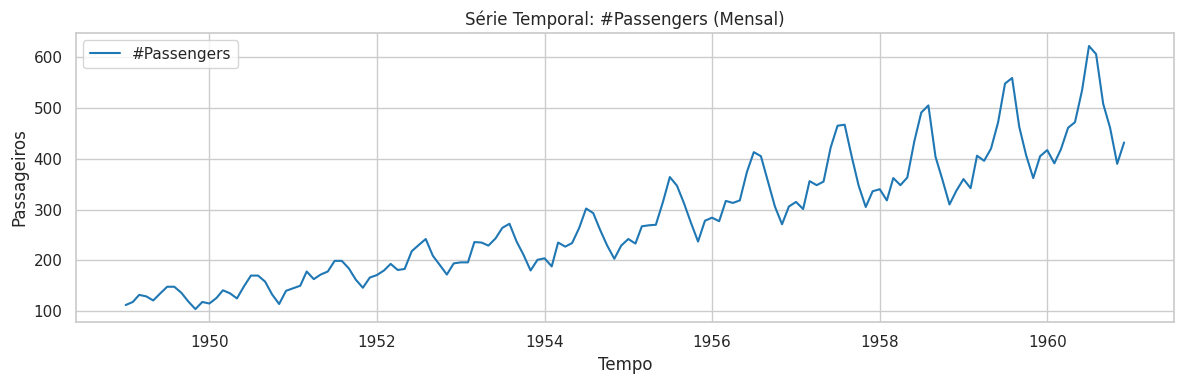


Decomposição sazonal (modelo multiplicativo):


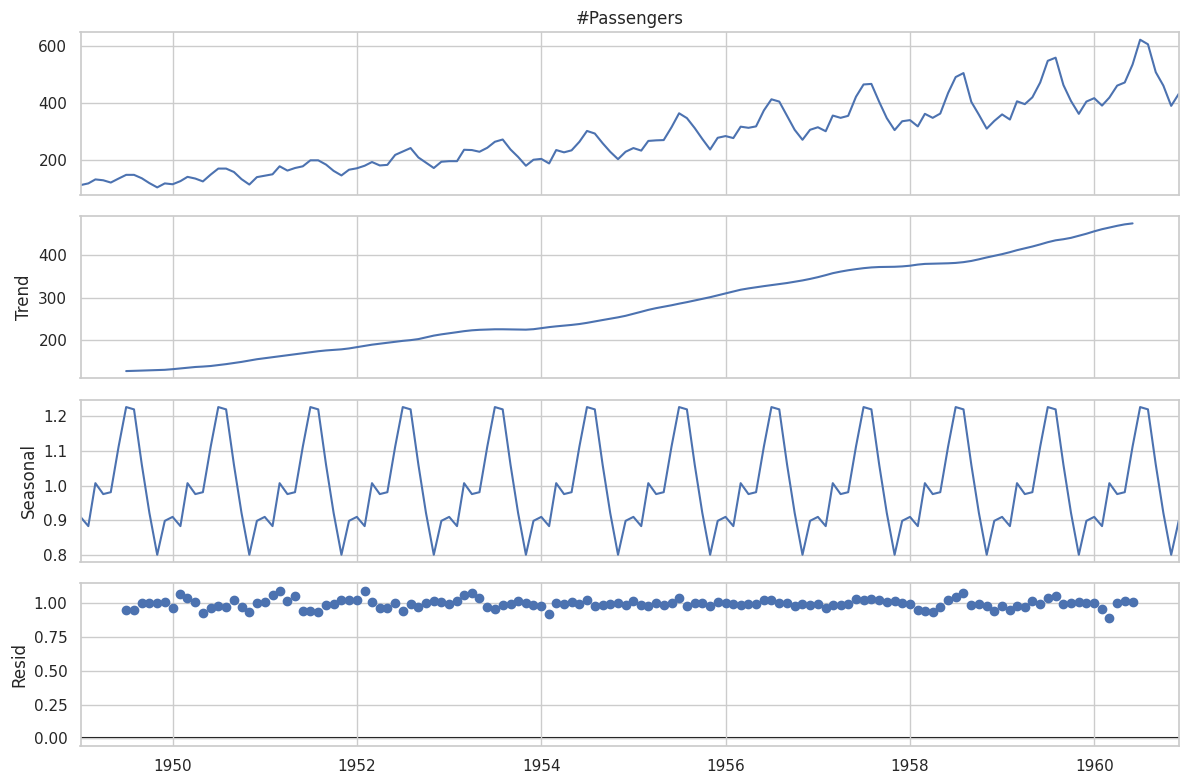

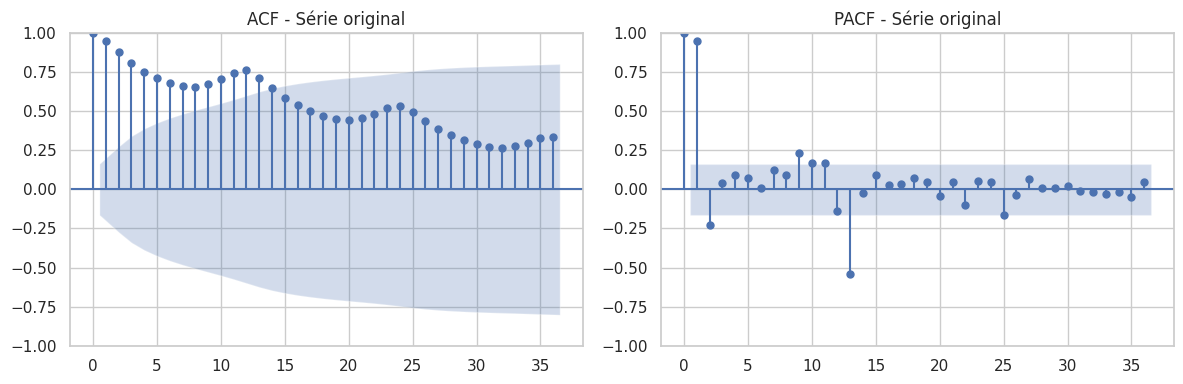


Testes na série original:
ADF Original: stat=0.815, p=0.9919, lags=13, nobs=130 -> Não estacionária (p>=0.05)
KPSS Original: stat=1.651, p=0.0100, lags=8 -> Não estacionária (rejeita H0)

Testes após transformações (log, diff, diff sazonal):
ADF log-diff: stat=-2.717, p=0.0711, lags=14, nobs=128 -> Não estacionária (p>=0.05)
KPSS log-diff: stat=0.038, p=0.1000, lags=6 -> Estacionária (não rejeita H0)
ADF log-diff12: stat=-2.710, p=0.0724, lags=12, nobs=119 -> Não estacionária (p>=0.05)
KPSS log-diff12: stat=0.292, p=0.1000, lags=6 -> Estacionária (não rejeita H0)

=== ETAPA 3: Modelagem (SARIMA vs RandomForest com Lags) ===
- SARIMA (statsmodels SARIMAX): seleção de ordens por AIC em grade pequena.
- ML: RandomForestRegressor com lags 1..12, médias/desvios móveis (12) e mês.

Divisão temporal: treino até 1958-12-01 | teste de 1959-01-01 a 1960-12-01 (h=24)

Selecionando ordens por AIC (p,q in 0..2; d in {0,1}; P,Q in {0,1}; D in {0,1}; m=12)...
Melhor SARIMA por AIC: order=(1, 0, 0), 

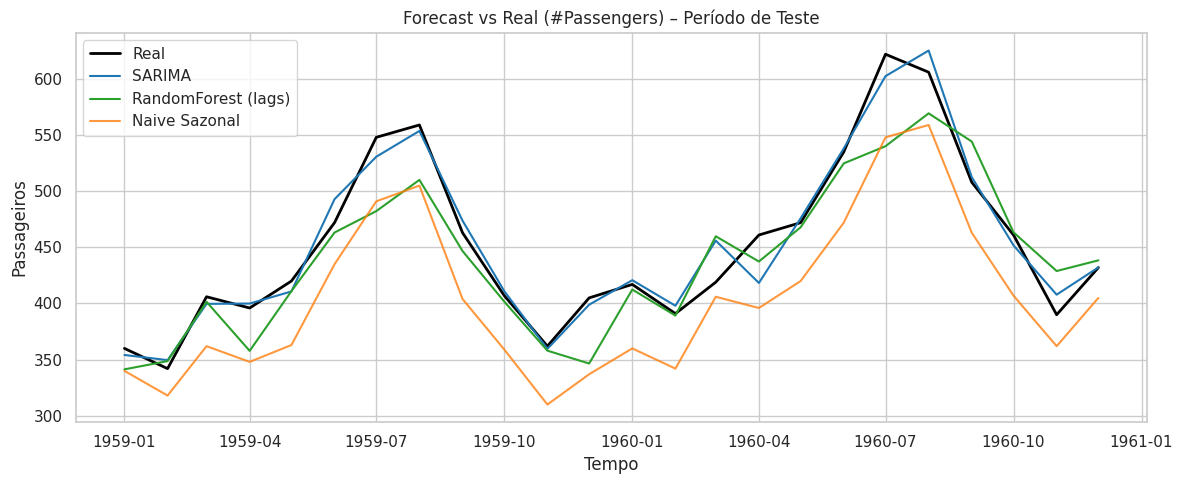


=== ETAPA 6: Diagnósticos (Bônus) ===
Durbin-Watson (SARIMA)      : 2.935
Durbin-Watson (RandomForest): 1.389

Ljung-Box (lag ajustado) p-valor — SARIMA: 0.10033559374287818
Ljung-Box (lag ajustado) p-valor — RF    : 0.8699491307205262
Interpretação: p<0.05 sugere autocorrelação remanescente (modelo pode estar subajustado).


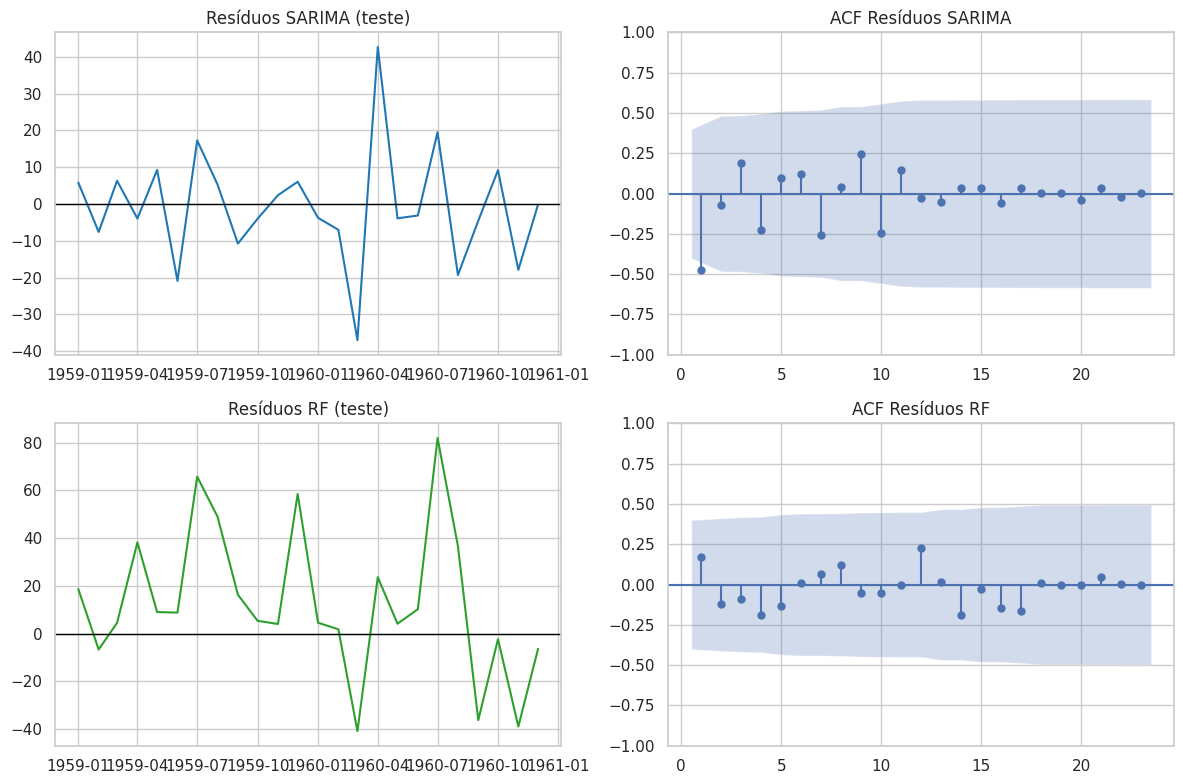


=== ETAPA 7: Conclusões ===
- Série com tendência e forte sazonalidade (m=12): SARIMA sazonal é apropriado.
- Selecionamos (p,d,q)(P,D,Q,12) por AIC numa grade pequena (eficiente e estável).
- Modelo de ML usou lags 1..12, estatísticas móveis (12) e mês, com RF re-treinado a cada passo.
- Walk-forward (1 passo) evita vazamento temporal e simula uso real.
- Baseline Naive Sazonal é forte; bons modelos devem superá-lo.
- Diagnósticos (DW e Ljung-Box) checam autocorrelação remanescente.
- Limitações: SARIMA assume linearidade; RF não fornece incerteza.


In [16]:
# Série Temporal Univariada: AirPassengers (mensal)
# - EDA e decomposição
# - Testes ADF e KPSS
# - Modelagem SARIMA (statsmodels SARIMAX) com seleção de ordens por AIC (grade pequena)
# - Modelo ML (RandomForest) com lag features
# - Walk-forward validation (1 passo)
# - Métricas: MAE, RMSE, MAPE
# - Diagnósticos: Durbin-Watson e Ljung-Box
# - Gráficos: série, decomposição, forecast vs real, ACF dos resíduos

def rodar_pipeline_series_temporais():
    import warnings
    warnings.filterwarnings("ignore")

    import io
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Upload no Colab (fallback automático se não houver upload)
    try:
        from google.colab import files
        COLAB = True
    except Exception:
        COLAB = False

    # Stats e Modelos
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    from statsmodels.tsa.seasonal import seasonal_decompose
    from statsmodels.tsa.stattools import adfuller, kpss
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    from statsmodels.stats.diagnostic import acorr_ljungbox
    from statsmodels.stats.stattools import durbin_watson
    import statsmodels.api as sm

    sns.set(style="whitegrid")
    pd.set_option("display.max_columns", None)

    # =========================================================
    # ETAPA 1: CARREGAMENTO DOS DADOS
    # =========================================================
    print("\n=== ETAPA 1: Carregamento dos Dados ===")
    print("Esperado: CSV com colunas 'Month' e '#Passengers' (ou 'Passengers'/'value').")
    print("Ex.:")
    print("Month,#Passengers\n1949-01,112\n1949-02,118\n...")

    df = None
    if COLAB:
        try:
            print("\n--- ⬆️ Faça o upload do seu CSV ---")
            uploaded = files.upload()
            if uploaded:
                fname = list(uploaded.keys())[0]
                print(f"Arquivo '{fname}' recebido. Lendo...")
                df = pd.read_csv(io.BytesIO(uploaded[fname]))
        except Exception as e:
            print(f"Aviso: upload não realizado ({e}). Usando dataset padrão 'Airline Passengers'.")

    if df is None:
        # Fallback: dataset padrão do statsmodels
        from statsmodels.datasets import airline
        df_std = airline.load_pandas().data  # colunas: 'month', 'value'
        df_std.rename(columns={"month": "Month", "value": "#Passengers"}, inplace=True)
        df = df_std.copy()

    # Padronizar nomes de colunas
    df.columns = [c.strip() for c in df.columns]
    if "#Passengers" not in df.columns:
        if "Passengers" in df.columns:
            df.rename(columns={"Passengers": "#Passengers"}, inplace=True)
        elif "value" in df.columns:
            df.rename(columns={"value": "#Passengers"}, inplace=True)

    if "Month" not in df.columns or "#Passengers" not in df.columns:
        raise ValueError("CSV deve conter as colunas 'Month' e '#Passengers' (ou 'Passengers'/'value').")

    # Converter para datetime e ordenar
    df["Month"] = pd.to_datetime(df["Month"], errors="coerce")
    df = df.dropna(subset=["Month"]).sort_values("Month").reset_index(drop=True)

    # Definir índice temporal mensal
    df = df.set_index("Month")
    # Garantir frequência mensal (início do mês)
    try:
        df = df.asfreq("MS")
    except Exception:
        pass

    # Série alvo
    y = df["#Passengers"].astype(float)

    print("\nAmostra dos dados:")
    print(df.head())
    print(df.tail())
    print(f"\nPeríodo total: {y.index.min().date()} a {y.index.max().date()}")
    print(f"Número de observações: {len(y)}")

    # =========================================================
    # ETAPA 2: ANÁLISE EXPLORATÓRIA E TESTES
    # =========================================================
    print("\n=== ETAPA 2: Análise Exploratória e Testes ===")

    # Plot série
    plt.figure(figsize=(12, 4))
    plt.plot(y.index, y.values, label="#Passengers", color="#1f77b4")
    plt.title("Série Temporal: #Passengers (Mensal)")
    plt.xlabel("Tempo")
    plt.ylabel("Passageiros")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Decomposição (multiplicativa é adequada pois variância cresce com nível)
    print("\nDecomposição sazonal (modelo multiplicativo):")
    try:
        decomposition = seasonal_decompose(y, model="multiplicative", period=12)
    except Exception:
        decomposition = seasonal_decompose(y, model="additive", period=12)
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.tight_layout()
    plt.show()

    # ACF/PACF (com lags seguros)
    lags_ori = int(min(36, max(1, len(y) - 1)))
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(y, lags=lags_ori, ax=ax[0])
    plot_pacf(y, lags=lags_ori, ax=ax[1], method="ywm")
    ax[0].set_title("ACF - Série original")
    ax[1].set_title("PACF - Série original")
    plt.tight_layout()
    plt.show()

    # Testes de estacionariedade
    def run_adf(series, name=""):
        result = adfuller(series.dropna(), autolag="AIC")
        stat, p, lags, nobs = result[0], result[1], result[2], result[3]
        print(f"ADF {name}: stat={stat:.3f}, p={p:.4f}, lags={lags}, nobs={nobs} ->",
              "Estacionária" if p < 0.05 else "Não estacionária (p>=0.05)")
        return p

    def run_kpss_test(series, name=""):
        try:
            stat, p, lags, crit = kpss(series.dropna(), regression="c", nlags="auto")
            print(f"KPSS {name}: stat={stat:.3f}, p={p:.4f}, lags={lags} ->",
                  "Não estacionária (rejeita H0)" if p < 0.05 else "Estacionária (não rejeita H0)")
            return p
        except Exception as e:
            print(f"KPSS {name}: falhou ({e}).")
            return np.nan

    print("\nTestes na série original:")
    _ = run_adf(y, "Original")
    _ = run_kpss_test(y, "Original")

    # Transformação log para estabilizar variância
    y_log = np.log(y)
    y_log_diff = y_log.diff()
    y_log_diff_seas = y_log.diff(12)

    print("\nTestes após transformações (log, diff, diff sazonal):")
    _ = run_adf(y_log_diff.dropna(), "log-diff")
    _ = run_kpss_test(y_log_diff.dropna(), "log-diff")
    _ = run_adf(y_log_diff_seas.dropna(), "log-diff12")
    _ = run_kpss_test(y_log_diff_seas.dropna(), "log-diff12")

    # =========================================================
    # ETAPA 3: MODELAGEM (SARIMA vs RF com Lags)
    # =========================================================
    print("\n=== ETAPA 3: Modelagem (SARIMA vs RandomForest com Lags) ===")
    print("- SARIMA (statsmodels SARIMAX): seleção de ordens por AIC em grade pequena.")
    print("- ML: RandomForestRegressor com lags 1..12, médias/desvios móveis (12) e mês.")

    # Split temporal: usar últimos 24 meses como teste (ou 1/5 se série pequena)
    test_h = 24 if len(y) >= 60 else max(12, len(y) // 5)
    test_start = y.index[-test_h]
    print(f"\nDivisão temporal: treino até {y.loc[:test_start].index[-2].date()} | "
          f"teste de {test_start.date()} a {y.index[-1].date()} (h={test_h})")

    y_train_all = y.loc[y.index < test_start]
    y_log_train_all = np.log(y_train_all)

    # Grade de busca (pequena) para SARIMA
    p = q = range(0, 3)     # 0,1,2
    P = Q = range(0, 2)     # 0,1
    d_candidates = [0, 1]
    D_candidates = [0, 1]
    seasonal_period = 12

    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    print("\nSelecionando ordens por AIC (p,q in 0..2; d in {0,1}; P,Q in {0,1}; D in {0,1}; m=12)...")
    for di in d_candidates:
        for Di in D_candidates:
            for pi in p:
                for qi in q:
                    for Pi in P:
                        for Qi in Q:
                            order = (pi, di, qi)
                            seasonal_order = (Pi, Di, Qi, seasonal_period)
                            try:
                                model = sm.tsa.statespace.SARIMAX(
                                    y_log_train_all,
                                    order=order,
                                    seasonal_order=seasonal_order,
                                    trend="c",  # constante
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,
                                )
                                res = model.fit(disp=False)
                                aic = res.aic
                                if aic < best_aic:
                                    best_aic = aic
                                    best_order = order
                                    best_seasonal_order = seasonal_order
                            except Exception:
                                continue

    if best_order is None:
        # Fallback conservador
        best_order = (1, 1, 1)
        best_seasonal_order = (1, 1, 1, 12)
        print("Aviso: Falha na seleção por AIC. Usando ordem padrão (1,1,1)x(1,1,1,12).")
    else:
        print(f"Melhor SARIMA por AIC: order={best_order}, seasonal_order={best_seasonal_order}, AIC={best_aic:.2f}")

    # ---------- Funções auxiliares ----------
    def mape(y_true, y_pred):
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100.0

    def build_supervised(series, max_lag=12, add_roll=True):
        df_sup = pd.DataFrame({"y": series})
        for L in range(1, max_lag + 1):
            df_sup[f"lag_{L}"] = series.shift(L)
        if add_roll:
            df_sup["roll_mean_12"] = series.shift(1).rolling(window=12).mean()
            df_sup["roll_std_12"] = series.shift(1).rolling(window=12).std()
        df_sup["month"] = df_sup.index.month
        df_sup = df_sup.dropna()
        return df_sup

    sup = build_supervised(y, max_lag=12, add_roll=True)

    # Alinhar split para supervisionado (garantir lags disponíveis)
    sup_train = sup.loc[sup.index < test_start]
    sup_test = sup.loc[sup.index >= test_start]
    if len(sup_test) == 0:
        first_test_idx = sup.index.get_loc(test_start, method="backfill")
        test_start = sup.index[first_test_idx]
        sup_train = sup.loc[sup.index < test_start]
        sup_test = sup.loc[sup.index >= test_start]
        print(f"Ajuste de split (por lags): novo início de teste = {test_start.date()}")

    # ---------- Walk-forward validation ----------
    preds_sarima = []
    preds_rf = []
    preds_naive_seas = []
    y_test_vals = []

    test_dates = y.index[y.index >= test_start]
    print(f"\nIniciando Walk-Forward (passo=1) em {len(test_dates)} pontos...")

    for t in test_dates:
        # Histórico até t-1
        y_train_t = y.loc[y.index < t]
        y_log_train_t = np.log(y_train_t)

        # SARIMA com ordens fixas (reajuste a cada passo)
        try:
            model_t = sm.tsa.statespace.SARIMAX(
                y_log_train_t,
                order=best_order,
                seasonal_order=best_seasonal_order,
                trend="c",
                enforce_stationarity=False,
                enforce_invertibility=False,
            )
            res_t = model_t.fit(disp=False)
            yhat_log = res_t.forecast(1).iloc[0]
            yhat_sarima = float(np.exp(yhat_log))
        except Exception:
            # Fallback simples: persistência
            yhat_sarima = float(y_train_t.iloc[-1])

        # RandomForest com lags
        if t in sup.index:
            sup_train_t = sup.loc[sup.index < t]
            x_t = sup.loc[[t]].drop(columns=["y"])
            rf = RandomForestRegressor(
                n_estimators=500,
                max_depth=None,
                random_state=42,
                n_jobs=-1
            )
            rf.fit(sup_train_t.drop(columns=["y"]), sup_train_t["y"])
            yhat_rf = float(rf.predict(x_t)[0])
        else:
            yhat_rf = float(y_train_t.iloc[-1])

        # Naive sazonal
        if t - pd.DateOffset(months=12) in y.index:
            yhat_naive = float(y.loc[t - pd.DateOffset(months=12)])
        else:
            yhat_naive = float(y_train_t.iloc[-1])

        preds_sarima.append(yhat_sarima)
        preds_rf.append(yhat_rf)
        preds_naive_seas.append(yhat_naive)
        y_test_vals.append(float(y.loc[t]))

    # =========================================================
    # ETAPA 4: MÉTRICAS
    # =========================================================
    print("\n=== ETAPA 4: Métricas (MAE, RMSE, MAPE) ===")
    y_true = np.array(y_test_vals)
    preds_sarima = np.array(preds_sarima)
    preds_rf = np.array(preds_rf)
    preds_naive_seas = np.array(preds_naive_seas)

    def summarize_metrics(name, y_t, y_p):
        mae = mean_absolute_error(y_t, y_p)
        rmse = float(np.sqrt(mean_squared_error(y_t, y_p)))  # compatível com versões antigas de sklearn
        mape_val = mape(y_t, y_p)
        print(f"{name:>20} | MAE: {mae:8.3f} | RMSE: {rmse:8.3f} | MAPE: {mape_val:6.2f}%")
        return {"Modelo": name, "MAE": mae, "RMSE": rmse, "MAPE": mape_val}

    results = []
    results.append(summarize_metrics("SARIMA (SARIMAX)", y_true, preds_sarima))
    results.append(summarize_metrics("RandomForest (lags)", y_true, preds_rf))
    results.append(summarize_metrics("Naive Sazonal", y_true, preds_naive_seas))

    res_df = pd.DataFrame(results).sort_values("RMSE")
    print("\nResumo (ordenado por RMSE):")
    print(res_df)

    # =========================================================
    # ETAPA 5: GRÁFICOS – Forecast vs Real
    # =========================================================
    print("\n=== ETAPA 5: Gráficos (Forecast vs Real – período de teste) ===")
    plt.figure(figsize=(12, 5))
    plt.plot(test_dates, y_true, label="Real", color="black", linewidth=2)
    plt.plot(test_dates, preds_sarima, label="SARIMA", color="#1f77b4")
    plt.plot(test_dates, preds_rf, label="RandomForest (lags)", color="#2ca02c")
    plt.plot(test_dates, preds_naive_seas, label="Naive Sazonal", color="#ff7f0e", alpha=0.8)
    plt.title("Forecast vs Real (#Passengers) – Período de Teste")
    plt.xlabel("Tempo")
    plt.ylabel("Passageiros")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # =========================================================
    # ETAPA 6: DIAGNÓSTICOS (Bônus)
    # =========================================================
    print("\n=== ETAPA 6: Diagnósticos (Bônus) ===")
    resid_sarima = y_true - preds_sarima
    resid_rf = y_true - preds_rf

    dw_sarima = durbin_watson(resid_sarima)
    dw_rf = durbin_watson(resid_rf)
    print(f"Durbin-Watson (SARIMA)      : {dw_sarima:.3f}")
    print(f"Durbin-Watson (RandomForest): {dw_rf:.3f}")

    # Lags seguros para Ljung-Box (não exceder tamanho-2 e >=1)
    lb_lag_sar = int(min(12, max(1, len(resid_sarima) - 2)))
    lb_lag_rf = int(min(12, max(1, len(resid_rf) - 2)))
    lb_sarima = acorr_ljungbox(resid_sarima, lags=[lb_lag_sar], return_df=True)
    lb_rf = acorr_ljungbox(resid_rf, lags=[lb_lag_rf], return_df=True)
    print("\nLjung-Box (lag ajustado) p-valor — SARIMA:", float(lb_sarima['lb_pvalue'].iloc[0]))
    print("Ljung-Box (lag ajustado) p-valor — RF    :", float(lb_rf['lb_pvalue'].iloc[0]))
    print("Interpretação: p<0.05 sugere autocorrelação remanescente (modelo pode estar subajustado).")

    # Resíduos – gráfico + ACF com lags seguros
    lags_res_sar = int(min(24, max(1, len(resid_sarima) - 1)))
    lags_res_rf = int(min(24, max(1, len(resid_rf) - 1)))

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    ax[0,0].plot(test_dates, resid_sarima, color="#1f77b4"); ax[0,0].axhline(0, color="black", lw=1)
    ax[0,0].set_title("Resíduos SARIMA (teste)")
    plot_acf(resid_sarima, lags=lags_res_sar, ax=ax[0,1], zero=False); ax[0,1].set_title("ACF Resíduos SARIMA")

    ax[1,0].plot(test_dates, resid_rf, color="#2ca02c"); ax[1,0].axhline(0, color="black", lw=1)
    ax[1,0].set_title("Resíduos RF (teste)")
    plot_acf(resid_rf, lags=lags_res_rf, ax=ax[1,1], zero=False); ax[1,1].set_title("ACF Resíduos RF")

    plt.tight_layout()
    plt.show()

    # =========================================================
    # ETAPA 7: CONCLUSÕES
    # =========================================================
    print("\n=== ETAPA 7: Conclusões ===")
    print("- Série com tendência e forte sazonalidade (m=12): SARIMA sazonal é apropriado.")
    print("- Selecionamos (p,d,q)(P,D,Q,12) por AIC numa grade pequena (eficiente e estável).")
    print("- Modelo de ML usou lags 1..12, estatísticas móveis (12) e mês, com RF re-treinado a cada passo.")
    print("- Walk-forward (1 passo) evita vazamento temporal e simula uso real.")
    print("- Baseline Naive Sazonal é forte; bons modelos devem superá-lo.")
    print("- Diagnósticos (DW e Ljung-Box) checam autocorrelação remanescente.")
    print("- Limitações: SARIMA assume linearidade; RF não fornece incerteza.")

# Execute
rodar_pipeline_series_temporais()